# Section 3
Create a daily sales forecast by channel for the next 90 days.
- Explain which method you chose and why.
- Explain how you evaluated your results.
- Summarize the accuracy of the forecast.

## Load

In [1]:
import pandas as pd
from datetime import date

# load raw data
df = pd.read_csv(
    'ecom_data.csv',
    dtype={
        'SalesOrder': str,
        'SKU': str,
        'Description': str,
        'UnitPrice': float,
        'CustomerID': int,
        'Channel': str,
        'State': str,
        'Sales': float,
        'Quantity': int
    },
    converters={
        'InvoiceDay': date.fromisoformat
    })

# drop duplicates
df.drop_duplicates(inplace=True)

# restrict to sales
df = df[df.Quantity > 0].reset_index(drop=True)

## Initial Thoughts

Before diving into modeling, let's re-examine the 10 day rolling average for daily sales by channel.

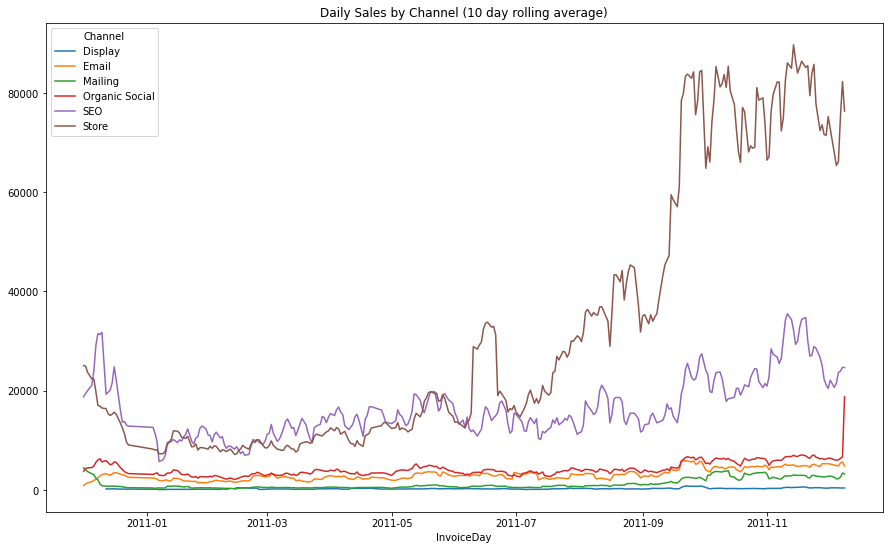

In [2]:
df_rolling = df.groupby(['Channel', 'InvoiceDay'])\
                .agg({'Sales': 'sum'})\
                .rolling(10)\
                .mean()\
                .dropna()

df_rolling.reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='Channel', values='Sales')\
    .plot(figsize=(15, 9), title="Daily Sales by Channel (10 day rolling average)");

We can tell that there's a clear upward trend for store and mailing sales, while it's less clear if the other channels exhibit upward sales growth.

Because of the clear differences in sales per channel, we'll want to consider using a hierarchical model to forecast sales - one model for each channel, whose results we could aggregate to an overall sales forcast.

Before we start, we'll want to identify any distinct time related trends we'll need to account for. While there seems to be a clear seasonal trend (with sales peaking towards the holidays and tapering off throughout the winter), we should also check to see if there's a weekly trend to see if sales tend to peak during certain days of the week. We can use an autocorrelation plot to see if there's any evidence for such a relationship:

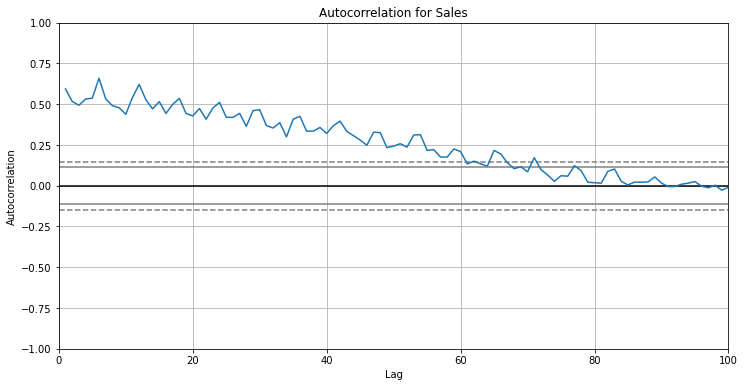

In [3]:
import matplotlib.pyplot as plt

# get sales by day
df_days = df.groupby('InvoiceDay')\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)\
    .sort_values('InvoiceDay', ascending=True)

# plot autocorrelation
fig = plt.figure(figsize=(12, 6), )
ax = pd.plotting.autocorrelation_plot(df_days.set_index('InvoiceDay'), figure=fig)
ax.set_xlim([0, 100])
ax.set_title("Autocorrelation for Sales")
ax.plot(figsize=(12, 9));

There doesn't appear to be any such relationship. If there was, we'd expect to see spikes in the autocorrelation coefficient for lag values that are multiples of 7. But, just to confirm  - let's check with the Store channel. That's the most likely candidate for weekly trends, as most brick and mortar retail shopping tends to be done on the weekends.

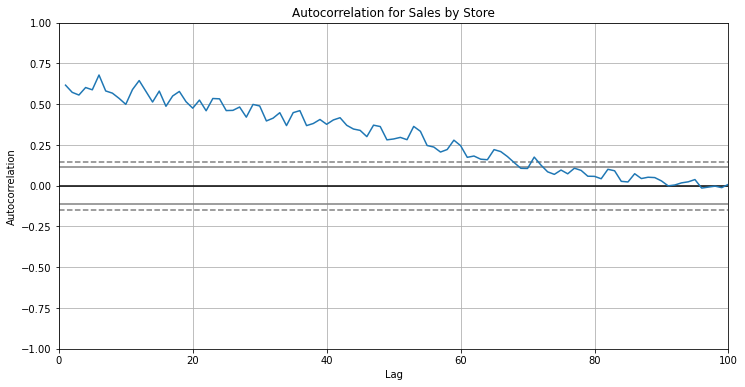

In [4]:
# get sales by day for Store
df_store = df[df.Channel == 'Store'].groupby('InvoiceDay')\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)\
    .sort_values('InvoiceDay', ascending=True)

# plot autocorrelation
fig = plt.figure(figsize=(12, 6), )
ax = pd.plotting.autocorrelation_plot(df_store.set_index('InvoiceDay'), figure=fig)
ax.set_xlim([0, 100])
ax.set_title("Autocorrelation for Sales by Store")
ax.plot(figsize=(12, 9));

This is similar to the plot for total sales, and doesn't show any evidence for a weekly trend in sales.

Given the limited nature of the dataset and its relatively small time window (less than 1 years' worth of data isn't enough to find an accurate estimate for the seasonal effect), we can fit a sinusoidal curve with a linear trend to create a simple forecast function that should reasonably project sales for the next 90 days.

While we could try to use a more complex model like SARIMAX for our forecast, there simply isn't enough data to justify it. Let's create the function and plot a fitted curve (note that we'll keep using `Store` sales for now).

We'll use `scipy.optimize.curve_fit` to fit our curve, and we'll use MAPE and RMSE to measure how well it fits the data. `scipy.optimize.curve_fit` uses non-linear least squares to fit a function, which is what we want as we're fitting a curve. MAPE and RMSE are common measures of model fit, and we'll use them to compare how well different curves fit the data.

MAPE: 104.85
RMSE: 593512501.01


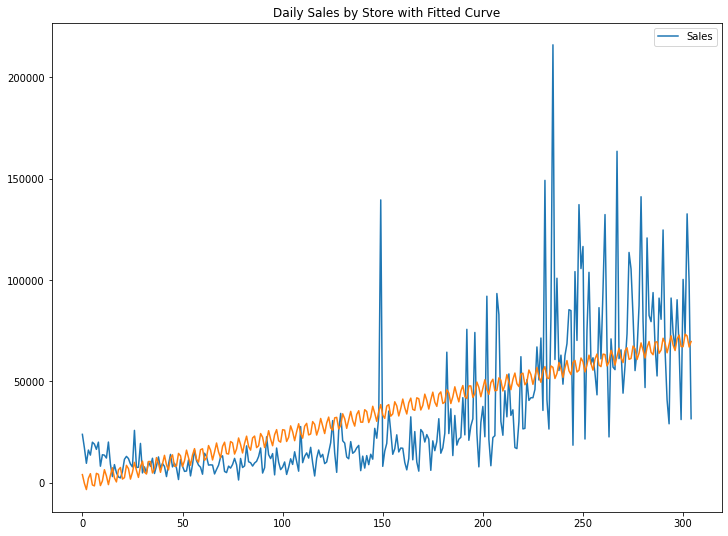

In [129]:
import numpy as np
from scipy import optimize

def curve_func(x, amp, freq, phase, trend):
    """Function for a sinusoidal curve with a linear trend component.
    
    ARGS
    - amp: Amplitude of wave.
    - freq: Frequency of wave.
    - phase: Phase shift of wave.
    - trend: Linear trend component.
    
    RETURN
    - Point along the curve given the args above.
    
    """
    return amp * np.sin(freq * x + phase) + trend * x

def fit_curve_func(x, y, p0=[1,1,0,0], curve_func=curve_func):
    """Get parameters, MAPE and RMSE for optimize.curve_fit(curve_func, x, y, p0).
    
    ARGS
    - x: The independant variable.
    - y: The dependant variable.
    - p0: Initial values for the curve_func parameters.
    - curve_func: The curve function to fit.
    
    RETURN
    - dict of parameters, MAPE and RMSE.
    
    """
    # fit curve, get params
    params, params_covariance = optimize.curve_fit(curve_func, x, y, p0=p0)
    
    # get fitted values
    y_hat = [curve_func(i, *params) for i in x]
    
    # calculate MAPE
    mape = np.mean(np.abs((y - y_hat) / y_hat)) * 100
    
    # calculate RMSE
    rmse = np.mean((y - y_hat) ** 2)
    
    return {'params': params, 'MAPE': mape, 'RMSE': rmse}

# set params
x = df_store.index.values
y = df_store.Sales

# fit curve, get parameters and accuracy measures
results = fit_curve_func(x, y)

# plot sales, predicted values
print(f"MAPE: {round(results['MAPE'], 2)}")
print(f"RMSE: {round(results['RMSE'], 2)}")
ax = df_store.plot(figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve")
ax.plot([curve_func(i, *results['params']) for i in x]);

Doesn't look great. We should tune our parameters some to find a better fit. We'll use grid search on a small number of parameters to find a better curve:

In [130]:
from sklearn.model_selection import ParameterGrid

# setup grid
params_grid = {
    'amp': [-100000, -10000, -1000, -100, 0, 100, 1000, 10000, 100000],
    'freq': [-1, -.1, 0, .1, 1],
    'phase': [-10000, -1000, -100, 0, 100, 1000, 10000],
    'trend': [0, 100, 1000]
}

# run grid search
results = []
for params in ParameterGrid(params_grid):
    try:
        result = fit_curve_func(x,y,list(params.values()))
        results.append(result)
    except RuntimeError:
        # NOTE: scipy will throw a RuntimeError if Optimal parameters cannot be found.
        #       Only happens with some parameter combinations.
        print(f"Failed to fit params {params}")

/Users/robert/.pyenv/versions/3.8.2/envs/comoto_takehome/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


MAPE: 40.52
RMSE: 474291507.13
Params:
    amp:	16367.0445
    freq:	-0.0195
    phase:	-99.5876
    trend:	224.8126


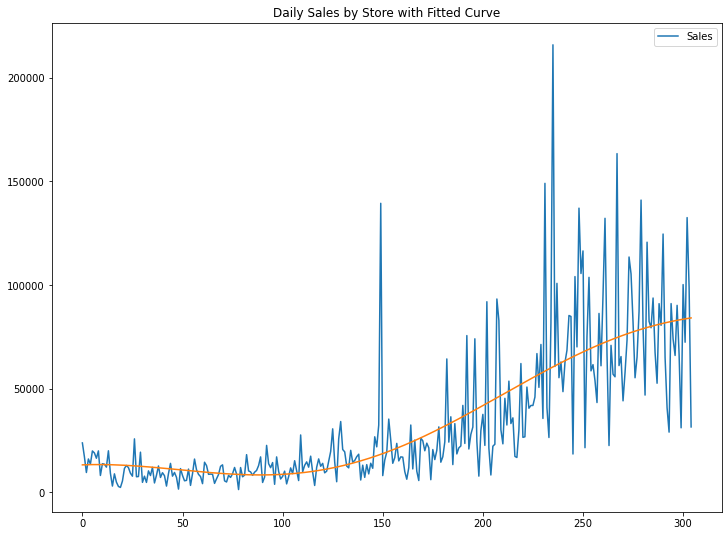

In [131]:
# get params for best fit by RMSE
results.sort(key=lambda r: r['RMSE'])
best_fit = results[0]

# plot sales, predicted values with 90 day forecast
print(f"MAPE: {round(best_fit['MAPE'], 2)}")
print(f"RMSE: {round(best_fit['RMSE'], 2)}")
print(f"Params:")
for k,v in zip(params_grid.keys(), best_fit['params']):
    print(f"    {k}:\t{round(v, 4)}")

ax = df_store.plot(figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve")
ax.plot([curve_func(i, *best_fit['params']) for i in x]);

That looks much better, and our accuracy metrics have improved by a large margin. Let's extend the curve to our 90 day forecast window to see if it behaves as expected:

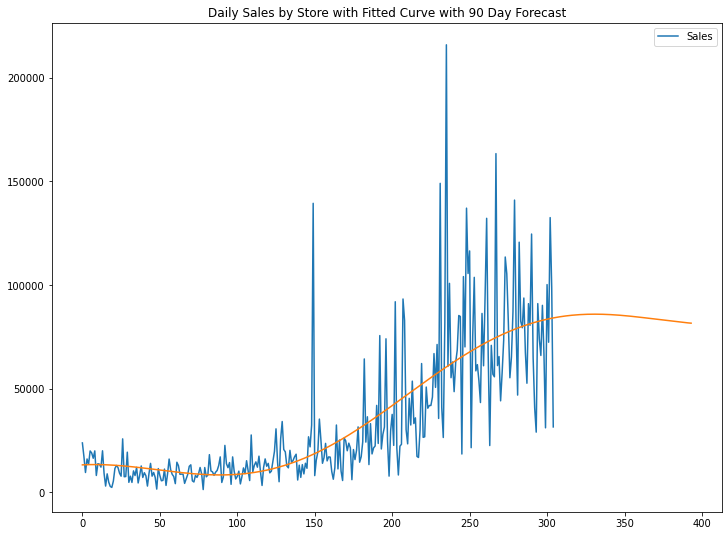

In [132]:
ax = df_store.plot(figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve with 90 Day Forecast")
ax.plot([curve_func(i, *best_fit['params']) for i in range(0, 394)]);

Much better! The curve exhibits a downward trend throughout the winter months, which is the seasonal trend we expect given the downward trend at the start of our dataset.

If I had more time, I'd explore expanding this into a hierarchical model. But for now, let's try this approach on overall sales and see if it still fits well.

In [138]:
# get daily sales numbers
df_sales = df.groupby('InvoiceDay')\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)

# set params
x = df_sales.index.values
y = df_sales.Sales

# setup grid
params_grid = {
    'amp': [-100000, -10000, -1000, -100, 0, 100, 1000, 10000, 100000],
    'freq': [-1, -.1, 0, .1, 1],
    'phase': [-10000, -1000, -100, 0, 100, 1000, 10000],
    'trend': [0, 100, 1000]
}

# run grid search
results = []
for params in ParameterGrid(params_grid):
    try:
        result = fit_curve_func(x,y,list(params.values()))
        results.append(result)
    except RuntimeError:
        # NOTE: scipy will throw a RuntimeError if Optimal parameters cannot be found.
        #       Only happens with some parameter combinations.
        print(f"Failed to fit params {params}")

/Users/robert/.pyenv/versions/3.8.2/envs/comoto_takehome/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


MAPE: 41.16
RMSE: 984616218.42
Params:
    amp:	20072.6807
    freq:	0.0201
    phase:	-10001.2485
    trend:	385.6269


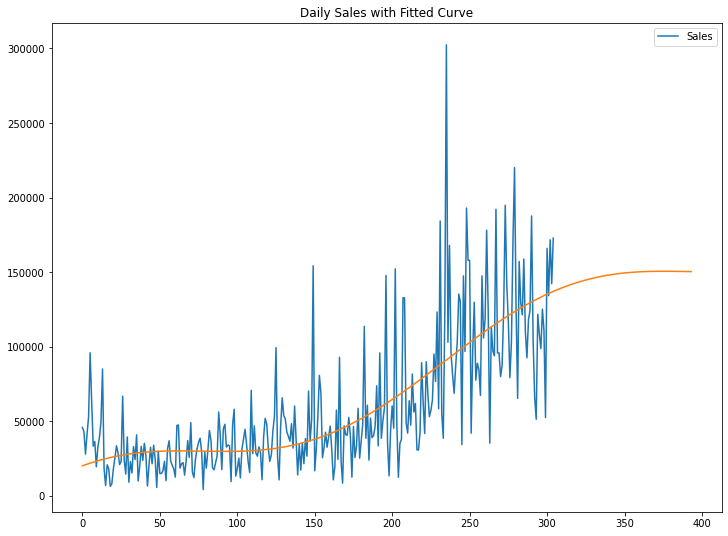

In [139]:
# get params for best fit by RMSE
results.sort(key=lambda r: r['RMSE'])
best_fit = results[0]

# plot sales, predicted values with 90 day forecast
print(f"MAPE: {round(best_fit['MAPE'], 2)}")
print(f"RMSE: {round(best_fit['RMSE'], 2)}")
print(f"Params:")
for k,v in zip(params_grid.keys(), best_fit['params']):
    print(f"    {k}:\t{round(v, 4)}")

ax = df_sales.plot(figsize=(12, 9))
ax.set_title("Daily Sales with Fitted Curve")
ax.plot([curve_func(i, *best_fit['params']) for i in range(0, 394)]);

Not as well. While the MAPE value is similar to the curve we fit on Sales by Store, the curve doesn't quite exhibit the seasonal behavior we'd expect - sales after the holidays should drop off more drastically. With some more tuning, we could likely get it to fit like the curve on Sales by Store above. But in the interest of time, we'll move on.

## Summary

Given the limited nature of the dataset and its relatively small time window (less than 1 years' worth of data isn't enough to find an accurate estimate for the seasonal effect), I used a sinusoidal curve with a linear trend to create a simple forecast function that should reasonably project sales for the next 90 days.
